In [52]:
import pandas as pd
import scipy.io as io
import h5py
import numpy as np
import matplotlib.pyplot as plt
#from repositorio_v2 import teorico, fit_bode
#import scipy.signal as sp
import scipy.optimize as op

#### FUNCIONES PARA EL AJUSTE DEL BODE

In [53]:
### Necesitamos lo siguiente 

def funcion_fit(x,w,y):
    ##Funcion que adapta los datos de la curva
    a1 = x[0]
    d1 = x[1]
    a2 = x[2]
    alfa = x[3]
    
    num = 1 + (d1*w*1j)**alfa
    error = abs(a1/num + a2)-y
    
    return error


def generaDatos_ApartirDeParametros(w,x):
    ##Funcion que genera los datos a partir de los componentes de la curva
    ##LA funcin solo permite llamar de uno en uno

    mag = []
    phase = []
    for w_i in w:
        a1 = x[0]
        d1 = x[1]
        a2 = x[2]
        alfa = x[3]
        
        aux = 1 + (d1*w_i*1j)**alfa
        num = a1/aux + a2
        mag.append(abs(num))
        phase.append(np.angle(num, deg = True))

    return mag,phase


def score(mag_fit,phase_fit,mag_raw,phase_raw):
    ## Function returning the values of the phase and the mag errors
    if(len(mag_fit)!=len(mag_raw)):
        print("Espectro de frecuencias distitnto. No es comparable")
        return 1
    
    error_mag_fit = abs(np.mean([(i-e)/e for i,e in zip(mag_fit,mag_raw)]))
    error_phase_fit = abs(np.mean([(i-e)/e for i,e in zip(phase_fit,phase_raw)]))

    return error_mag_fit,error_phase_fit

    
def genera_p_iniciales_v3(p_iniciales,bound_inferior,bound_superior,num_p_iniciales,bound_absoluto_inferior,bound_absoluto_superior, var = 0.05, var_bound = 0.05):
    ##### Random generator function to change the initial parameters
    
    ###### --------------
    
    ###---------Bound inferior
    e_neg = np.random.uniform(low = -var_bound, high=0)
    e_pos = np.random.uniform(low = 0, high=var_bound)

    bound_inferior_0 = [ bound_inferior[0]*(1+e_neg) if bound_inferior[0]*(1+e_neg)>bound_absoluto_inferior[0] else bound_inferior[0],  ##Bound inferior para magnitud en DC
                    0,  ##Bound inferior para el polo
                    bound_inferior[2]*(1+e_neg) if bound_inferior[2]*(1+e_neg)>bound_absoluto_inferior[2] else bound_inferior[2],  ## Bound inferior para la magnitud en Inf
                    bound_inferior[3]*(1+e_neg) if bound_inferior[3]*(1+e_neg)>bound_absoluto_inferior[3] else bound_inferior[3]] ## Bound inferior para alfa

    ###-----------Bound superior
    bound_superior_0 = [np.inf, ##Bound superior para magnitud en DC
                    bound_superior[1]*(1+e_pos) if bound_superior[1]*(1+e_pos)>bound_absoluto_superior[1] else bound_superior[1], ##Bound superior para el polo 
                    bound_superior[2]*(1+e_pos) if bound_superior[2]*(1+e_pos)>bound_absoluto_superior[2] else bound_superior[2], ##Bound superior para magnitud en Inf
                    1] ##Bound superior para alfa

    ##### --------------Generamos los parametros iniciales a partir de los bounds
    p_i_t = []
    for ip,p in enumerate(p_iniciales):
        p_i_t.append(  [float(p*(1+e)) if (bound_superior_0[ip]<=float(p+p*e)>= bound_inferior_0[ip]) else p for e in np.random.uniform(low = -var, high=var, size=num_p_iniciales)  ])
    
    print ("p_i_t",p_i_t)
    print(len(p_i_t))

    ##En vez de hacer un zip hacemos otra cosa
    p_iniciales_total = []
    for i in range(num_p_iniciales):
        p_iniciales_total_i = []
        for k in range(len(p_i_t)):
            p_iniciales_total_i.append(p_i_t[k][i])
        p_iniciales_total.append(p_iniciales_total_i)
    #p_iniciales_total = zip(p_i_t[0],p_i_t[1],p_i_t[2])


    print ("p_iniciales_total",p_iniciales_total)

    return bound_inferior_0,bound_superior_0,p_iniciales_total

def rutina_fit_v3(w,mag_raw,phase_raw,plot = True, error_max = 0.05 ):
    
    mag_dc = list(mag_raw)[0]
    polo_init = w[0]/4/np.pi
    mag_inf = list(mag_raw)[-1]
    alfa_init = 0.7

    x0 = [mag_dc,polo_init,mag_inf,alfa_init] ## Pasamos los parametros iniciales como los teoricos del fit
    bound_inferior = [mag_dc*0.9,  ##Bound inferior para magnitud en DC
                    0,  ##Bound inferior para el polo
                    mag_inf*0.99,  ## Bound inferior para la magnitud en Inf
                    0.65] ##Bound inferior para alfa

    bound_superior = [np.inf, ##Bound superior para magnitud en DC
                    (w[0]/2/np.pi)*10, ##Bound superior para el polo 
                    
                    mag_inf*1.01, ##Bound superior para magnitud en Inf
                    1] ##Bound superior para alfa

    bound_inferior_abs, bound_superior_abs = bound_inferior, bound_superior


    #### -------------Fit te los parametros
    res_lsq = op.least_squares(funcion_fit, x0,loss="linear", f_scale=0, ftol = 1e-15, gtol = 1e-15, xtol = 1e-15,
                                args=(w, mag_raw),bounds=(bound_inferior,bound_superior) ) 

    mag_fit,phase_fit = generaDatos_ApartirDeParametros(w, res_lsq.x)

    f = w/(2*np.pi)



    #####--------------------------ALGORTIMOS GENETICOS------------------------------------------------
    mag_dc,polo_fit,mag_inf,alfa_init = res_lsq.x

    rct_eq_fit = mag_dc-mag_inf
    rsol_eq_fit = mag_inf
    cdl_eq_fit = 1/(rct_eq_fit*polo_fit)
    alfa = alfa_init

    mejor_fit = [mag_fit,phase_fit,rct_eq_fit,rsol_eq_fit,cdl_eq_fit,alfa]

    error_relativo_mag, error_relativo_phase = score(mag_fit,phase_fit,mag_raw,phase_raw)

    print("Error relativo inicial: "+str(abs(error_relativo_mag)*100)+" %")

    iter_max = 10
    p_iniciales = x0
    i = 0

    while(i<iter_max and error_relativo_mag>0.01): ##Esto es un 1% 

        
        #### P_iniciales a partir de un bound te genera 1 bound_inferior y otro superior y muchas iteraciones diferentes
        bound_inferior_i,bound_superior_i,p_iniciales_iteracion = genera_p_iniciales_v3(p_iniciales,bound_inferior,bound_superior,10,bound_inferior_abs, bound_superior_abs,var = error_max, var_bound = error_max)
        
        Bound_inferior_hijos = []
        Bound_superior_hijos = []

        error_mag_hijos = []
        #Funcion puntua_hijos
        for p_iniciales_i in p_iniciales_iteracion:

            res_lsq = op.least_squares(funcion_fit, x0,loss="linear", f_scale=0, ftol = 1e-15, gtol = 1e-15, xtol = 1e-15,
                                args=(w, mag_raw),bounds=(bound_inferior_i,bound_superior_i) ) 

            mag_fit,phase_fit = generaDatos_ApartirDeParametros(w, res_lsq.x)

            error_mag_fit,error_phase_fit = score(mag_fit,phase_fit,mag_raw,phase_raw)

            error_mag_hijos.append(error_mag_fit)    
            Bound_inferior_hijos.append(bound_inferior_i)
            Bound_superior_hijos.append(bound_superior_i)


            if(error_relativo_mag>=error_mag_fit):

                mag_dc,polo_fit,mag_inf,alfa = res_lsq.x

                rct_eq_fit = mag_dc-mag_inf
                rsol_eq_fit = mag_inf
                cdl_eq_fit = 1/(rct_eq_fit*polo_fit)
                
                ##Actualizamos parametros
                mejor_fit = [mag_fit,phase_fit,rct_eq_fit,rsol_eq_fit,cdl_eq_fit,alfa]
                p_iniciales = p_iniciales_i

                error_relativo_mag = error_mag_fit
                error_relativo_phase = error_phase_fit

        ## Y los limites del bound 
                
        mejores = list(sorted(error_mag_hijos,reverse=True))[:10]
        indices_mejores = [error_mag_hijos.index(i) for i in mejores]
        Bound_inferior_mejores = [i for ix,i in enumerate(Bound_inferior_hijos) if ix in indices_mejores]
        Bound_superior_mejores = [i for ix,i in enumerate(Bound_superior_hijos) if ix in indices_mejores]
        
        ##Ahora tenemos 100 destos que lo que haremos es la media de cada parametro 
        bound_inferior = [np.mean(i) for i in list(zip(*Bound_inferior_mejores))]
        bound_superior = [np.mean(i) for i in list(zip(*Bound_superior_mejores))]

        i+=1


    ####-------------------FIN ALGORITMOS GENETICOS------------------------------------------------------

    mag_fit,phase_fit,rct_eq_fit,rsol_eq_fit,cdl_eq_fit,alfa = mejor_fit
    f = w/(2*np.pi)

    if(plot):

        print("")
        print("-----------VALORES FIT-----------------------")
        print("Rsol_fit:", format(rsol_eq_fit, ".1E"))
        print("Rct_fit:", format(rct_eq_fit, ".1E"))
        print("Cdl_fit:", format(cdl_eq_fit, ".1E"))
        print("alfa:", format(alfa_init, ".1E"))
        print("Tao:", format(polo_fit, ".1E"))
        print("-----------ERRORES FIT-----------------------")
        print("Error mag: %", format(abs(error_relativo_mag)*100, ".1E"))
        print("Error phase: %", format(abs(error_relativo_phase)*100, ".1E"))

        w_plot = w
        f_plot = w_plot/(2*np.pi)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4),dpi = 200)
        ## BODE RAW
        ax1.loglog(f, mag_raw,'.',label = "Magnitud raw") # Eje x logarítmico
        ax2.semilogx(f, phase_raw,'.', label = "Phase raw") # Eje x logarítmico

        ## BODE FIT
        mag_fit_plot,phase_fit_plot = mag_fit,phase_fit
        ax1.loglog(f_plot, mag_fit_plot,label = "Magnitud fit") # Eje x logarítmico
        ax2.semilogx(f_plot, phase_fit_plot,label = "Magnitud fit") # Eje x logarítmico

        ax2.set_ylabel("Phase (deg)")
        ax1.set_ylabel("Magnitud (Nat)")

        ax2.set_xlabel("Freq (Hz)")
        ax1.set_xlabel("Freq (Hz)")

    print("Error relativo final: "+str(abs(error_relativo_mag)*100)+ " %")

    print("")

    return rct_eq_fit,rsol_eq_fit,cdl_eq_fit,alfa,polo_fit,abs(error_relativo_mag*100),abs(error_relativo_phase*100),f,mag_raw,phase_raw,mag_fit,phase_fit


def box_plot(dt):

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    ax1, ax2, ax3, ax4 = axs[0,0], axs[0,1], axs[1,0], axs[1,1]

    ax1.boxplot(dt["rct_fit"], showmeans = True, meanline = True, showfliers= False)
    ax1.set_title("RCT FIT")

    ax2.boxplot(dt["rsol_fit"], showmeans = True, meanline = True, showfliers= False)
    ax2.set_title("RSOL FIT")

    ax3.boxplot(dt["cdl_fit"], showmeans = True, meanline = True, showfliers= False)
    ax3.set_title("CDL FIT")

    ax4.boxplot(dt["alfa"], showmeans = True, meanline = True, showfliers= False)
    ax4.set_title("ALFA FIT")

    for ax in axs.flat:
        ax.set_yscale('linear')
        #ax.set_yticklabels([])  

### BODE FUNCTION TO RUN


Error relativo inicial: 2.279431234380973 %
p_i_t [[2400000.0, 2400000.0, 2400000.0, 2400000.0, 2400000.0, 2400000.0, 2400000.0, 2400000.0, 2400000.0, 2400000.0], [np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5)], [182.23030012839277, 174.72, 174.72, 178.95948999816665, 174.72, 174.72, 182.66392595180432, 174.72, 174.72, 178.64476966811165], [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]]
4
p_iniciales_total [[2400000.0, np.float64(0.5), 182.23030012839277, 0.7], [2400000.0, np.float64(0.5), 174.72, 0.7], [2400000.0, np.float64(0.5), 174.72, 0.7], [2400000.0, np.float64(0.5), 178.95948999816665, 0.7], [2400000.0, np.float64(0.5), 174.72, 0.7], [2400000.0, np.float64(0.5), 174.72, 0.7], [2400000.0, np.float64(0.5), 182.66392595180432, 0.7], [2400000.0, np.float64(0.5), 174.72, 0.7], [2400000.0, np.float64(0.5), 174.72, 0.7], [2400000.0, np.float64(0.5), 178.644769

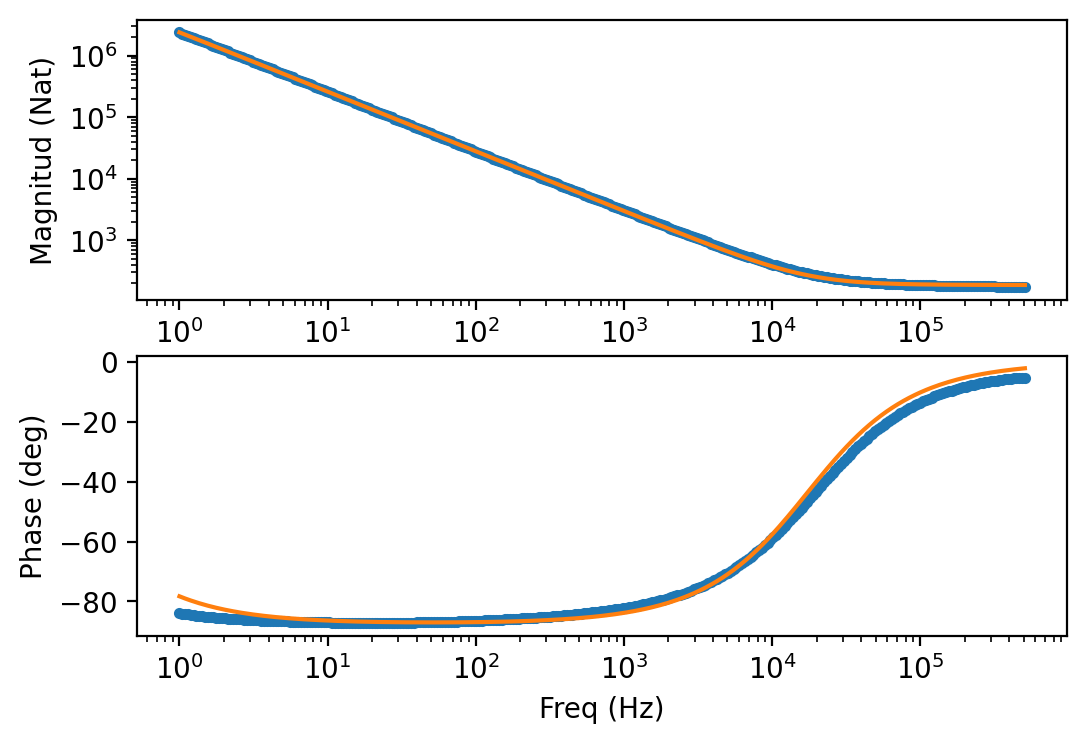

In [54]:
path = "C:/Users/jeanp/Documents/ENSEA/STAGES/2A/Travaux/Data.xlsx"
datos = pd.read_excel(path)
datos.columns = ["freq","mag_imp","phase_imp"]
w,mag_raw,phase_raw = 2*np.pi*datos["freq"],datos["mag_imp"],datos["phase_imp"]*(180/np.pi) ##Bueno claro z_sensing no es el sistema que quiero

rct_eq_fit,rsol_eq_fit,cdl_eq_fit,alfa,tau_fit,error_relativo_mag,error_relativo_phase,f,mag_raw,phase_raw,mag_fit,phase_fit = rutina_fit_v3(w,mag_raw,phase_raw,plot = True,error_max = 0.05)



In [55]:
float(rct_eq_fit)
print(abs(1+2j))

2.23606797749979


### AJUSTES BODE PARA SWEEP EN DC